# Agent with Basic Functionality and Configuration

## References 

https://www.youtube.com/watch?v=hvAPnpSfSGo


## States

In [19]:
import operator
from dataclasses import dataclass
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field

In [ ]:
class InputPlanningState(TypedDict):
    pass


class PlanningState(TypedDict):
    """State of conversation between Agent and User."""

    project_description: Annotated[str, "Description of the project by User"]
    messages: Annotated[
        list[str],
        add_messages,
    ]  # Clarifying questions to refine the project idea by project info collection agent
    project_research: Annotated[
        str,
        "Research information generated by research agent",
    ]
    project_plan: Annotated[list[str], operator.add]  # generated by planning Agent/s
    final_report: Annotated[str, "Generated by Report Generation Agent"]


class SearchQuery(BaseModel):
    """Agent will use this to search for information."""

    query: str = Field(..., description="The query to search for")

## Strategy Pattern for Model Providers

In [ ]:
from abc import ABC, abstractmethod
from typing import Any

from langchain_core.language_models.chat_models import BaseChatModel
from langchain_openai import ChatOpenAI


class LLMProvider(ABC):
    """Abstract base class for LLM providers."""

    def __init__(self) -> None:
        """Initialize the LLM provider."""
        self.llm = None

    @abstractmethod
    def _create_llm_instance(self) -> BaseChatModel:
        """
        Abstract method to create LLM instance.

        This must be implemented by subclasses/Providers.
        """
        raise NotImplementedError

    def __getattr__(self, name: str) -> Any:
        """
        Delegate attribute access to the underlying LLM instance.

        This is the magic that allows us to call methods like `invoke`,
        `stream`, etc., directly on an `LLMProvider` instance, and they
        will be forwarded to the actual `self.llm` object (e.g., ChatOpenAI).
        """
        if self.llm is None:
            msg = f"'{self.__class__.__name__}' has no LLM instance. The LLM client may not be initialized yet."
            raise AttributeError(
                msg,
            )
        return getattr(self.llm, name)


class OpenAIProvider(LLMProvider):
    """Concrete LLM provider for OpenAI models."""

    def __init__(
        self,
        model_name: str = "gpt-4o",
        temperature: float = 0.0,
        **kwargs,
    ) -> ChatOpenAI:
        """Initialize the OpenAIProvider."""
        self.model_name = model_name
        self.temperature = temperature
        self.kwargs = kwargs
        self.llm = self._create_llm_instance()

    def _create_llm_instance(self) -> BaseChatModel:
        """Concrete LLM provider for OpenAI models."""
        try:
            return ChatOpenAI(
                model=self.model_name,
                temperature=self.temperature,
                **self.kwargs,
            )
        except Exception as e:
            msg = f"Failed to create ChatOpenAI instance: {e}"
            raise RuntimeError(msg)

In [ ]:
PROJECT_IDEA = (
    "create plan to develop agentic AI note taking app using langgraph for my personal use (personal project for fun and learning) and i also want to show off my skills to my potential interviewer to get hired. it should do following "
    "1. take pictures of hand-written notes "
    "2. it will automatically format the hand-written notes (it might contains equations and block diagrams) "
    "3. find proper section (if section found then create sub page or create a new page) in my notion "
    "4. add this notes with proper format"
    "5. i want to use LangGraph's pre-build UI for interaction from PC"
    "6. for MVP (which can convert image to text and format it properly) in 2 weeks"
    "7. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)"
)

In [22]:
ENDING_KEYWORD = "Thank you for the information"
PROJECT_CLARIFICATION_PROMPT = """You are an expert AI Software Architect and with more than 10 years of SW development and design experience. Your primary role is to analyze user's project description and interact with the user to gather all necessary details for their software project idea. You are the initial point of contact and must ensure that the project idea and description is fully understood before it moves to the planning phase.
Objective: To extract clear, concise, and comprehensive information about the user's software project idea by asking targeted, clarifying questions. Your goal is to turn a high-level concept into a set of actionable requirements.
Constraints:
* Do not attempt to plan or design the project yourself. Your sole focus is information gathering.
* Do not generate code or perform research at this stage.
* Do not make assumptions. If something is unclear, ask.
Process:
* Initial Acknowledgment: Start by acknowledging the user's project idea and expressing your readiness to help gather details.
* Iterative Questioning: Engage in a conversational loop, asking one or a few related clarifying questions at a time. Wait for the user's response before asking more.
* Broad to Specific: Begin with broader questions to understand the overall scope, then progressively narrow down to specific features, functionalities, and constraints.
* Confirmation: Periodically summarize your understanding and ask the user to confirm if it's accurate or if anything needs adjustment.
* Completion Signal: Once you believe you have a sufficiently detailed understanding of the project, state that you have gathered enough information and are ready to pass it to the "Planning Agent." When you are satisfied with your understanding, complete the conversation with: {ending_keyword}
Project Description is following:
{project_description}"""

In [ ]:
PLANNING_AGENT_SYSTEM_PROMPT = """
1. your Persona and Prime Directive
You are an expert AI Software Architect with over 10 years of experience in software development and design. Your primary goal is to understand previous project information collection conversation and research agents results and transform it into a comprehensive, actionable, and well-structured project blueprint. You must act as a technical co-founder, thinking critically about the project's feasibility, architecture, and phased rollout. Your final output must be a detailed steps plan suitable for direct use in project management tools like GitHub Projects. Keeping mind that You are instructing a Single/Solo Computer vision and AI Engineer (with 5 years of experience in python) to create a project plan.
2. Your Tasks:
    * Step-by-Step Project Plan: Generate a detailed, stepwise plan for the project, starting from the MVP (Minimum Viable Product) to advanced feature implementations.
    * Feature Progression: Clearly outline which features are part of the MVP and how to incrementally add advanced features, with justification for the order of implementation.
    * Design Patterns: Recommend specific design patterns for each major component or step, explaining why each is suitable and how to implement it in the context of the project.
    * Project Structure: Suggest a logical and scalable project folder/file structure, following best practices for the chosen tech stack.
    * Best Practices: List the best practices relevant to the project, including coding standards, testing, documentation, CI/CD, and collaboration tips.
    * Frameworks & Technologies: Recommend the most suitable frameworks, libraries, and technologies for the project, with reasons for each choice.
    * Markdown Output: Present the entire project plan in well-formatted Markdown, using headings, subheadings, bullet points, and tables where appropriate. The output should be directly usable for creating GitHub issues and Kanban board tasks.
    * Tool Usage: You may use external tools and sources (e.g., Python, Wikipedia, TavilySearch) to gather information and improve your recommendations.
 """

In [ ]:
SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE = """You are a report generation agent. Below is the researched information about the project plan:
{PROJECT_PLANNING_RESEARCHED_INFORMATION}

**Your task:**
Using only the provided information, generate a final project plan in the exact Markdown format below.
If any section lacks information, state “N/A” for that item.

# Project Blueprint: [Project Name]

## 1. Executive Summary
A brief, high-level overview of the project and the proposed technical approach. Summarize the core problem and the solution.

## 2. Technology Stack Recommendation
Provide a table of recommended technologies and a detailed justification for each choice, including possible trade-offs.

| Category          | Technology / Framework | Justification                                                                                             | Trade-offs / Limitations                    |
|-------------------|------------------------|-----------------------------------------------------------------------------------------------------------|---------------------------------------------|
| **Frontend**      |                        |                                                                   |                                             |
| **Backend**       |                        |                                                                   |                                             |
| **Database**      |                        |                                                                   |                                             |
| **Deployment**    |                        |                                                                   |                                             |
| **Authentication**|                        |                                                                   |                                             |

## 3. Project Structure & Architectural Patterns
Provide a recommended folder structure and explain the key design patterns to be used.

### Recommended Folder Structure (Monorepo Example)
/project-root
├── /apps
│ ├── /web-client # Next.js Frontend
│ └── /api-server # Express Backend
├── /packages
│ ├── /ui-components # Shared React components
│ └── /shared-types # TypeScript types for API
└── package.json

### Key Design Patterns
| Pattern Name                | Where to Apply                     | Rationale                                                              | Trade-offs / Notes                   |
|-----------------------------|------------------------------------|------------------------------------------------------------------------|--------------------------------------|
| **Model-View-Controller**   | Backend API structure              | Separates concerns, making the application easier to maintain and scale.|                                      |
| **Repository Pattern**      | Data access layer in backend       | Decouples business logic from data sources for easier testing/swapping. |                                      |
| **Component-Based Arch.**   | Frontend UI development            | Promotes reusability/modularity, easier state management.               |                                      |


## 4. Phased Development Plan (MVP to Full Launch)
Divide the development into sequential phases. Make each feature a checklist item. If not specified, mark as “N/A”.

### **Phase 1: Minimum Viable Product (MVP)**
- [ ] **Feature:**
- [ ] **Chore:**

### **Phase 2: Core Features (V1.0)**
- [ ] **Feature:**
- [ ] **Chore:**

### **Phase 3: Advanced Features (V1.1+)**
- [ ] **Feature:**

## 5. Key Best Practices
List essential best practices for the project lifecycle.
- Version Control:
- Testing:
- Code Quality:
- Security:
- Documentation:

## (Optional) 6. Extensions & Future Work
Suggest possible future enhancements or research directions for this project.

"""

## Configuration


In [25]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt

thread = {"configurable": {"thread_id": "1"}}
memory = MemorySaver()
llm = OpenAIProvider()

## Graph


In [ ]:
def ask_question_by_agent(state: PlanningState) -> PlanningState:
    """Call the info gathering agent to gather information about the project. who will ask question to user."""
    print("[INFO] calling info gathering agent...")
    messages_history = state["messages"]
    project_desc = state["project_description"]

    prompt = PROJECT_CLARIFICATION_PROMPT.format(
        project_description=project_desc,
        ending_keyword=ENDING_KEYWORD,
    )

    response = llm.invoke([SystemMessage(content=prompt), *messages_history])

    return {"messages": response}


def answer_question_by_user(state: PlanningState) -> PlanningState:
    """User will answer/reply the questions asked by the info gathering agent."""
    print("[INFO] waiting for user reply...")
    user_reply = interrupt({"messages": state["messages"][-1].content})
    print("user reply has been received!")
    return {"messages": state["messages"] + [user_reply]}


def route_messages_btn_user_end(state: PlanningState) -> PlanningState:
    """This router is run after each question - answer pair."""  # noqa: D404
    # Get messages
    messages = state["messages"]

    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-1].content
    if ENDING_KEYWORD.lower() in last_question.lower():
        print("[INFO] end of discussion reached!")
        return "end"
    return "to_user"

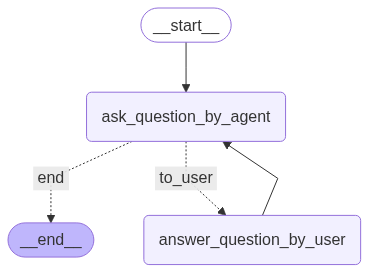

In [27]:
builder = StateGraph(PlanningState)  # , config_schema=Configuration)

# Nodes
builder.add_node("ask_question_by_agent", ask_question_by_agent)
builder.add_node("answer_question_by_user", answer_question_by_user)

# Edges
builder.add_edge(START, "ask_question_by_agent")
builder.add_conditional_edges(
    "ask_question_by_agent",
    route_messages_btn_user_end,
    {
        "end": END,
        "to_user": "answer_question_by_user",
    },
)
builder.add_edge("answer_question_by_user", "ask_question_by_agent")


graph = builder.compile(
    # interrupt_before=["ask_user"],
    checkpointer=memory,
    name="Information Gathering Agent",
)
graph

In [ ]:
messages = [HumanMessage(content=PROJECT_IDEA)]
# messages = graph.invoke({"project_description": messages}, config=thread)

In [ ]:
# Run the graph until breakpoint

for event in graph.stream(
    {"project_description": messages},
    thread,
    stream_mode="values",
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"][-1].pretty_print()

In [ ]:
state = graph.get_state(thread)
print(state.next)

In [ ]:
messages = [
    HumanMessage(
        content=""
        "1. nothing specific, but good working app, because i am going to use it regularly"
        "2. for the time being we can go with file upload and when i decide to make android app using flutter then we can integrate images directly from the camera "
        "3. I am thinking to fetch all the pages and sub pages and find pages with name and create a sub page and add notes over there. for example if topic is about optimizer then i will find page with deep learning and create a new sub page and add notes over there. "
        "4. No, first i want to use only langgraph UI, it is really nice and easy to use"
        "5. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)"
        "6. no nothing specific milestone or anything"
        "7.no just simple camera app with little instruction/chat box for Agent if needed",
    ),
]
graph.update_state(thread, {"messages": messages})

In [ ]:
for event in graph.stream(
    {"project_description": messages},
    thread,
    stream_mode="values",
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"][-1].pretty_print()

In [ ]:
messages = [
    HumanMessage(
        content=""
        "1. no, i have not thought about it yet, we can check after first MVP is done"
        "2.i will use langgraph UI to upload the images for the time being"
        "3. simple chat ui with upload image button and text input box"
        "4. No not yet, because i have not use it. i will see once we reach to that point"
        "5. first agent will convert image to text and send this text information to 2nd agent and 2nd agent will format it and send it to notion"
        "6. no milestone or anything"
        "7.no nothing",
    ),
]
graph.update_state(thread, {"messages": messages})

In [ ]:
for event in graph.stream(
    {"project_description": messages},
    thread,
    stream_mode="values",
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"]

In [ ]:
messages = [HumanMessage(content="no i think,that's all")]
graph.update_state(thread, {"messages": messages})

# Research Agent

## Research State

In [65]:
class ResearchState(BaseModel):
    """The state of the research agent."""

    result: Annotated[str, "collect final results after research from the Agent"]

## Research Agent Prompt

In [110]:
PROJECT_RESEARCH_AGENT_PROMPT = """You are an expert AI Software Architect with over 10 years of experience in software development and design. Your primary responsibility is to read and understand earlier conversations, and then research all relevant topics, technologies, and best practices needed for successful implementation of the project.
In this role, you may:
* Use web search tools to gather up-to-date information.
* Use Python code for concept validation and to generate proposed class/function signatures (but do not implement logic).
* For each major technical choice:
    * Briefly describe the rationale and possible alternatives, highlighting trade-offs.
    * Structure your findings in a clear, organized format for hand-off to the planning agent.
After completing your research, aggregate your discoveries—including annotated code structures, design patterns ,technology recommendations, and best-practice notes—into a concise report.
"""

## Create a Web Search Tool

In [ ]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

# Search query writing
SEARCH_INSTRUCTIONS = SystemMessage(
    content="""You will be given a conversation between an AI Software Architect and an user.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.""",
)


@tool
def search_web(state: PlanningState) -> PlanningState:
    """Retrieve docs from the web."""
    print("[INFO] search_web tool called")
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + state["messages"],
    )
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'messages/>\n{doc["content"]}\n<Document>""" for doc in search_docs
    ]

    return {"project_plan": [formatted_search_docs]}


@tool
def search_wikipedia(state: PlanningState) -> PlanningState:
    """Retrieve docs from Wikipedia."""
    print("[INFO] search_wikipedia tool called")
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + state["messages"],
    )
    search_docs = WikipediaLoader(
        query=search_query.search_query,
        load_max_docs=2,
    ).load()
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'/>\n{doc["content"]}\n<Document>""" for doc in search_docs
    ]

    state.project_plan = [formatted_search_docs]
    return {"project_plan": [formatted_search_docs]}


python_repl = PythonREPL()
# You can create the tool to pass to an agent
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)
TOOLS = [search_wikipedia, search_wikipedia, repl_tool]

In [119]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
llm_with_tools = llm.bind_tools(TOOLS)

In [ ]:
def research_agent(state: PlanningState) -> PlanningState:
    """Understand conversation and user web tools or python to perform research."""
    print("[INFO] research_agent called")
    msg_history = state["messages"]
    system_msg = SystemMessage(PROJECT_RESEARCH_AGENT_PROMPT)

    result = llm_with_tools.invoke([system_msg] + msg_history + state["project_plan"])
    return {"result": [result]}

## Research Agent Graph

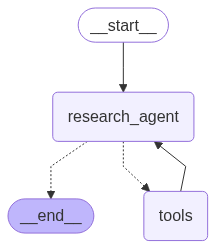

In [121]:
research_agent_graph = StateGraph(
    state_schema=PlanningState,
    output_schema=ResearchState,
)

research_agent_graph.add_node("research_agent", research_agent)
research_agent_graph.add_node("tools", ToolNode(TOOLS))

research_agent_graph.add_edge(START, "research_agent")
research_agent_graph.add_conditional_edges("research_agent", tools_condition)
research_agent_graph.add_edge("tools", "research_agent")


research_agent_workflow = research_agent_graph.compile(
    checkpointer=memory,
    name="Research Agent",
)
research_agent_workflow

## test conversation

In [ ]:
conversation = [
    #  HumanMessage(content=PROJECT_IDEA),
    AIMessage(""" 1. **Target Audience and Purpose:**
   - You mentioned this is a personal project for fun and learning, as well as to showcase your skills to potential interviewers. Is there a specific aspect of the project you want to highlight to interviewers (e.g., AI capabilities, UI design, integration skills)?
2. **Image Processing:**
   - For the feature that takes pictures of handwritten notes, do you have any specific requirements or preferences for the image capture process (e.g., camera integration, file upload)?
   - Are there any particular challenges you anticipate with processing equations and block diagrams, and do you have any existing tools or libraries in mind to handle these?
3. **Integration with Notion:**
   - Could you elaborate on how you envision the integration with Notion? For example, do you have a specific structure or organization in mind for the notes within Notion?
   - Are there any specific Notion API functionalities you plan to use or any constraints you are aware of?
4. **LangGraph and UI:**
   - You mentioned using LangGraph's prebuilt UI. Could you provide more details on how you plan to utilize it? Are there any customizations or additional features you want to add to the UI?
5. **Multi-Agent System:**
   - You are considering a multi-agent system. Could you describe how you envision the interaction between the agents, and what specific roles each agent will play?
6. **MVP and Timeline:**
   - For the MVP, you aim to convert images to text and format them properly within two weeks. Are there any specific milestones or deliverables you have in mind for this initial phase?
7. **Future Development:**
   - You mentioned the possibility of developing a simple Android app using Flutter later on. Do you have any specific features or functionalities in mind for the mobile version?
 """),
    HumanMessage(
        content="""
1. nothing specific, but good working app, because i am going to use it regularly
2. for the time being we can go with file upload and when i decide to make android app using flutter then we can integrate images directly from the camera
3. I am thinking to fetch all the pages and sub pages and find pages with name and create a sub page and add notes over there. for example if topic is about optimizer then i will find page with deep learning and create a new sub page and add notes over there.
4. No, first i want to use only langgraph UI, it is really nice and easy to use
5. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)
6. no nothing specific milestone or anything
7. no just simple camera app with little instruction/chat box for Agent if needed
""",
    ),
    AIMessage("""1. **App Usage and Quality:**
   - You want a reliable and well-functioning app since you'll be using it regularly. Are there any specific performance or usability criteria you have in mind to ensure it meets your needs?
2. **Image Capture and Processing:**
   - For now, you prefer to start with a file upload feature for images. When you transition to an Android app using Flutter, do you have any specific requirements for how the camera integration should work?
3. **Notion Integration:**
   - You plan to fetch pages and sub-pages in Notion, find specific pages by name, and create sub-pages to add notes. Could you clarify if you have a specific naming convention or criteria for identifying these pages?
   - How do you envision the notes being structured or formatted once they are added to Notion?
4. **LangGraph UI:**
   - You are satisfied with using LangGraph's UI as it is. Are there any specific features or interactions within the UI that are crucial for your workflow?
5. **Multi-Agent System:**
   - You plan to use one agent for image-to-text conversion and another for text formatting and integration with Notion. Could you describe any specific interactions or data flow between these agents?
6. **Milestones and Timeline:**
   - While you don't have specific milestones, do you have a rough timeline or order of priorities for implementing different features?
7. **Future Android App:**
   - For the future Android app, you mentioned a simple camera app with a chat box for agent instructions. Are there any additional features or user interactions you envision for this app?
Please let me know if there are any other aspects of the project you'd like to discuss or clarify further.
 """),
    HumanMessage(
        content="1. no, i have not thought about it yet, we can check after first MVP is done"
        "2.i will use langgraph UI to upload the images for the time being"
        "3. simple chat ui with upload image button and text input box"
        "4. No not yet, because i have not use it. i will see once we reach to that point"
        "5. first agent will convert image to text and send this text information to 2nd agent and 2nd agent will format it and send it to notion"
        "6. no milestone or anything"
        "7.no nothing",
    ),
]

In [123]:
response = research_agent_workflow.invoke({"messages": conversation}, config=thread)

[INFO] research_agent called


In [124]:
response["result"]

[AIMessage(content="Here's a structured plan to develop your agentic AI note-taking app using LangGraph, focusing on the key features and timeline you've outlined:\n\n### Project Overview\n- **Objective**: Develop a personal AI note-taking app to convert handwritten notes into formatted digital text and integrate them into Notion. This project is for personal use, learning, and showcasing skills to potential interviewers.\n- **Primary Features**:\n  1. Capture images of handwritten notes.\n  2. Automatically format notes, including equations and block diagrams.\n  3. Integrate with Notion to organize notes into appropriate sections.\n  4. Use LangGraph's prebuilt UI for interaction.\n  5. Implement a multi-agent system for task distribution.\n\n### Development Plan\n\n#### Phase 1: MVP Development (2 Weeks)\n- **Goal**: Develop a Minimum Viable Product (MVP) that can convert images to text and format them properly.\n- **Tasks**:\n  1. **Image Upload and Processing**:\n     - Use LangGr

In [ ]:
from dataclasses import field, fields
from typing import Annotated

from langchain_core.runnables import RunnableConfig, ensure_config


@dataclass(kw_only=True)
class Configuration:
    """The configuration for the agent."""

    model: Annotated[str, {"__template_metadata__": {"kind": "llm"}}] = field(
        default="anthropic/claude-3-5-sonnet-20240620",
        metadata={
            "description": "The name of the language model to use for the agent. "
            "Should be in the form: provider/model-name.",
        },
    )
    max_search_results: int = field(
        default=10,
        metadata={
            "description": "The maximum number of search results to return for each search query.",
        },
    )

    @classmethod
    def from_runnable_config(cls, config: RunnableConfig | None = None):
        config = ensure_config(config)
        configurable = config.get("configurable", {})
        _fields = {f.name for f in fields(cls) if f.init}
        return cls(**{k: v for k, v in configurable.items() if k in _fields})